# pyg test


In [1]:
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

import networkx as nx
import matplotlib.pyplot as plt

d:\anaconda3\envs\pyg_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Karate club network

In [2]:
from torch_geometric.datasets import KarateClub

dataset =KarateClub()
print(f"dataset: {dataset}")
print(f"number of graphs: {len(dataset)}")
print(f"number of features: {dataset.num_features}")
print(f"number of classes: {dataset.num_classes}")

data = dataset[0] # get the first graph object

# x means 样本 * 特征
# edge_index=[2, 156] source -> target的对
# y是标签
# train_mask 计算损失的时候选择哪些点去计算损失
print(data)


dataset: KarateClub()
number of graphs: 1
number of features: 34
number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


edge_index
* `edge_index`: 存储图的连接关系 (start -> end)
* `dataset.num_features`: 每个点的特征
* `train_mask`: 表示哪些节点用来计算损失

In [3]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

## 用networkx可视化展示


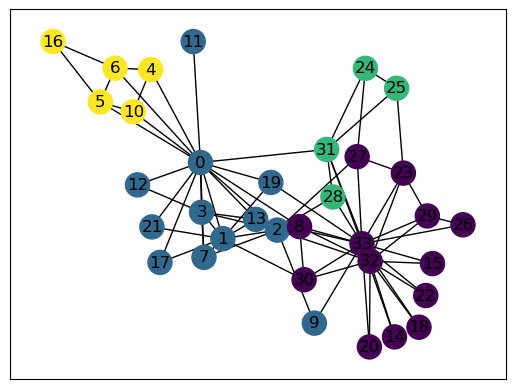

In [4]:
from torch_geometric.utils import to_networkx
G = to_networkx(data,to_undirected=True)
def plot_graph(G,labels):
    nx.draw_networkx(G,node_color=labels)
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_graph(G,labels=data.y)

## 定义一个GCN网络


In [5]:
import torch
import torch.nn as nn
from torch_geometric.nn import Sequential, GCNConv

class GCN(nn.Module):
    def __init__(self, input_channels, output_channels) -> None:
        super().__init__()

        torch.manual_seed(42)
        self.conv_block1 = Sequential('x, edge_index',[
            (GCNConv(input_channels, 4),'x, edge_index -> x'),
            nn.Tanh()
        ])

        self.conv_block2 = Sequential('x, edge_index',[
            (GCNConv(4, 4),'x, edge_index -> x'),
            nn.Tanh()
        ])

        self.conv_block3 = Sequential('x, edge_index',[
            (GCNConv(4, 2),'x, edge_index -> x'),
            nn.Tanh()
        ])
        
        self.fc = nn.Linear(2,output_channels)

    def forward(self, input): # 输入特征与邻接矩阵
        x = input[0]
        edge_index = input[1]
        x = self.conv_block1(x,edge_index)
        x = self.conv_block2(x,edge_index)
        x = self.conv_block3(x,edge_index)
        # print(x.shape)
        return self.fc(x), x # 返回两个输出结果，分类结果与fc上一层
    
model = GCN(dataset.num_features,dataset.num_classes)
print(model)

GCN(
  (conv_block1): Sequential(
    (0): GCNConv(34, 4)
    (1): Tanh()
  )
  (conv_block2): Sequential(
    (0): GCNConv(4, 4)
    (1): Tanh()
  )
  (conv_block3): Sequential(
    (0): GCNConv(4, 2)
    (1): Tanh()
  )
  (fc): Linear(in_features=2, out_features=4, bias=True)
)


In [8]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 训练模型(semi-supervised)

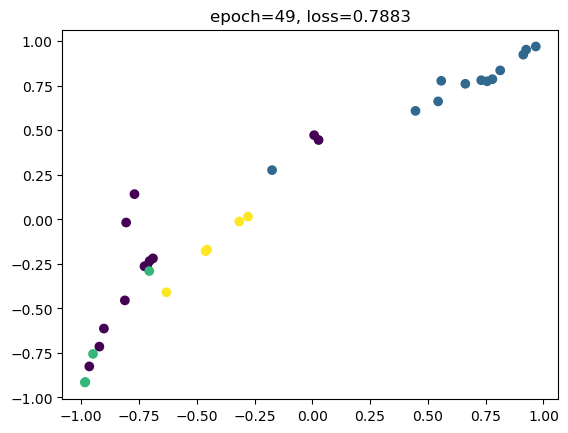

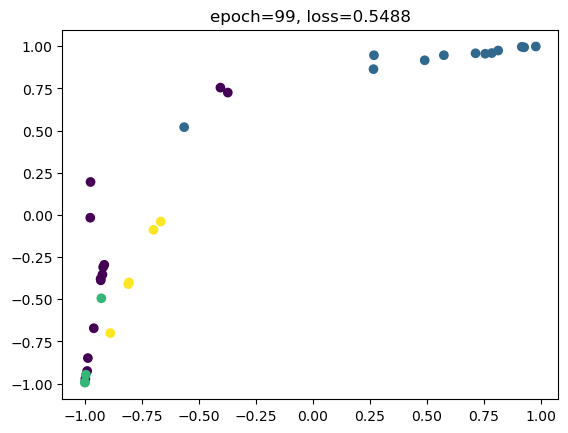

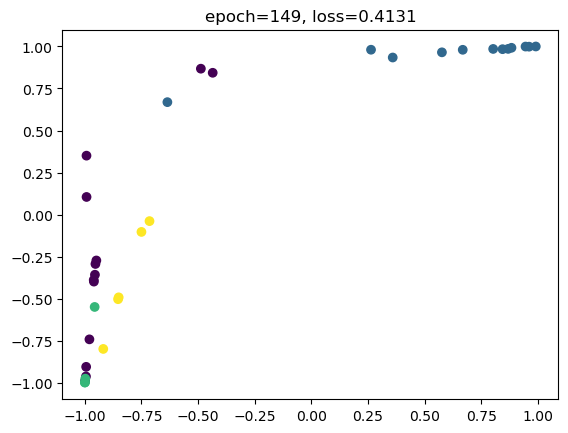

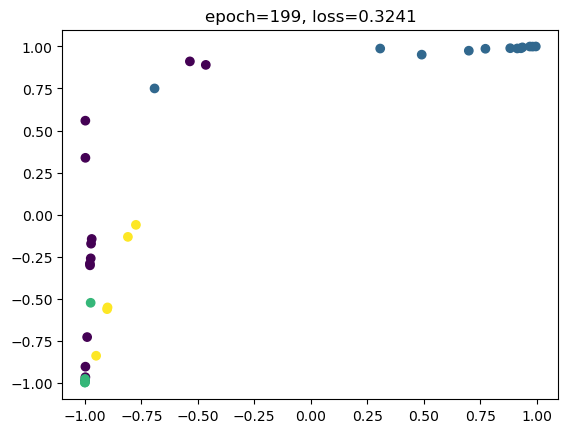

In [18]:
# device = 'cpu'
model = GCN(dataset.num_features,dataset.num_classes).to(device)

def plot_embeding(h, labels, epochs=None,loss=None):
    plt.scatter(h[:,0],h[:,1],c=labels)
    if (epoch is not None) and (loss is not None):
        plt.title(f'epoch={epoch}, loss={loss.item():.4f}')

    plt.show()


def train(data, lr=1e-2):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    
    optimizer.zero_grad()
    # input = (data.x,data.edge_index)

    data = data.to(device)
    outputs, h = model((data.x , data.edge_index)) # need to use a tuple structure
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # semi-supervised
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(200):
    loss, h = train(data=data)

    if (epoch + 1) % 50 == 0:
        h_cpu = h.detach().cpu().numpy()
        labels_cpu = data.y.detach().cpu().numpy()
        loss_cpu = loss.detach().cpu().numpy()
        plot_embeding(h_cpu,labels_cpu,epochs=epoch,loss=loss_cpu)


## 验证集加入